# Base Preprocessing Pipeline for Flight Delay Data

This notebook implements the fundamental preprocessing steps required for flight delay data that are common across all model types (Machine Learning, Deep Learning, and Time Series). These operations set the foundation for further specialized preprocessing.

## Key Processing Steps:
1. Loading and initial inspection of the data
2. Filtering out 2020 data due to COVID-19 irregularities
3. Basic data cleaning and type conversions
4. Detecting and removing duplicate records
5. Feature derivation that benefits all model types
6. Saving the preprocessed data for downstream pipelines

In [58]:
# Install and import required libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Configure paths dynamically using relative paths
import os.path as path

# Get the directory of the current notebook
notebook_dir = path.dirname(path.abspath('__file__'))
# Get project root (parent of notebooks directory)
project_root = path.abspath(path.join(notebook_dir, '..', '..'))

# Define paths relative to project root
RAW_DATA_PATH = path.join(project_root, 'data', 'raw', 'flights_sample_3m.csv')
PROCESSED_DATA_PATH = path.join(project_root, 'data', 'processed')

# Create processed data directory if it doesn't exist
os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
print(f"Raw data path: {RAW_DATA_PATH}")
print(f"Processed data path: {PROCESSED_DATA_PATH}")

# Display settings
pd.set_option('display.max_columns', None)
print("Libraries and paths configured.")

Raw data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\raw\flights_sample_3m.csv
Processed data path: c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed
Libraries and paths configured.


In [59]:
import pandas as pd

def load_and_filter_data(file_path, chunk_size=500000, filter_2020=True, drop_cancelled=True):
    """
    Load the entire dataset in chunks, apply filtering, and return a combined DataFrame.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file
    chunk_size : int
        Number of rows to load in each chunk
    filter_2020 : bool
        Whether to remove flights from 2020 due to COVID-19 irregularities
    drop_cancelled : bool
        Whether to drop cancelled flights

    Returns:
    --------
    pd.DataFrame
        Combined and filtered DataFrame
    """
    chunks = []

    for chunk in pd.read_csv(file_path, chunksize=chunk_size):
        # Convert all DATE columns to datetime
        date_columns = [col for col in chunk.columns if 'DATE' in col.upper()]
        for col in date_columns:
            chunk[col] = pd.to_datetime(chunk[col], errors='coerce')

        # Remove all rows where any DATE column has year 2020
        if filter_2020 and date_columns:
            for col in date_columns:
                chunk = chunk[~(chunk[col].dt.year == 2020)]

        # Drop cancelled flights
        if drop_cancelled and 'CANCELLED' in chunk.columns:
            chunk['CANCELLED'] = pd.to_numeric(chunk['CANCELLED'], errors='coerce')
            chunk = chunk[~(chunk['CANCELLED'] == 1)]

        chunks.append(chunk)

    # Concatenate all filtered chunks
    df_after_drop = pd.concat(chunks, ignore_index=True)
    return df_after_drop


In [60]:
# RAW_DATA_PATH = r'C:\xampp\htdocs\Forecasting_Flights-DataScience\data\raw\flights_sample_3m.csv'
rAW_DATA_PATH = path.join(project_root, 'data', 'raw', 'flights_sample_3m.csv')
df_after_drop = load_and_filter_data(RAW_DATA_PATH)


In [61]:
# Inspect the full filtered dataset
print(f"✅ Data shape after filtering: {df_after_drop.shape}")

print("\n🔍 Columns and data types:")
for col in df_after_drop.columns:
    print(f"- {col}: {df_after_drop[col].dtype}")

print("\n📄 Sample data (first 5 rows):")
display(df_after_drop.head())

# Check unique years in the dataset
if 'FL_DATE' in df_after_drop.columns:
    print("\n📅 Years in the dataset (after filtering):")
    print(df_after_drop['FL_DATE'].dt.year.value_counts().sort_index())


✅ Data shape after filtering: (2470267, 32)

🔍 Columns and data types:
- FL_DATE: datetime64[ns]
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: float64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: float64
- CANCELLATION_CODE: object
- DIVERTED: float64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64

📄 Sample data (first 5 rows):


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",1155,1151.0,-4.0,19.0,1210.0,1443.0,4.0,1501,1447.0,-14.0,0.0,NaN,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",2120,2114.0,-6.0,9.0,2123.0,2232.0,38.0,2315,2310.0,-5.0,0.0,NaN,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",954,1000.0,6.0,20.0,1020.0,1247.0,5.0,1252,1252.0,0.0,0.0,NaN,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",1609,1608.0,-1.0,27.0,1635.0,1844.0,9.0,1829,1853.0,24.0,0.0,NaN,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",1010,1237.0,147.0,15.0,1252.0,1328.0,3.0,1110,1331.0,141.0,0.0,NaN,0.0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0



📅 Years in the dataset (after filtering):
FL_DATE
2019    744079
2021    601101
2022    669412
2023    455675
Name: count, dtype: int64


✅ Total number of rows (after filtering 2020 and cancelled): 2,470,267

Missing value analysis:


,Column,Missing Values,Missing Percentage
21,CANCELLATION_CODE,2470267,100.000000
31,DELAY_DUE_LATE_AIRCRAFT,1980475,80.172508
27,DELAY_DUE_CARRIER,1980475,80.172508
30,DELAY_DUE_SECURITY,1980475,80.172508
29,DELAY_DUE_NAS,1980475,80.172508
28,DELAY_DUE_WEATHER,1980475,80.172508
19,ARR_DELAY,6288,0.254547
24,ELAPSED_TIME,6288,0.254547
25,AIR_TIME,6288,0.254547
15,WHEELS_ON,729,0.029511


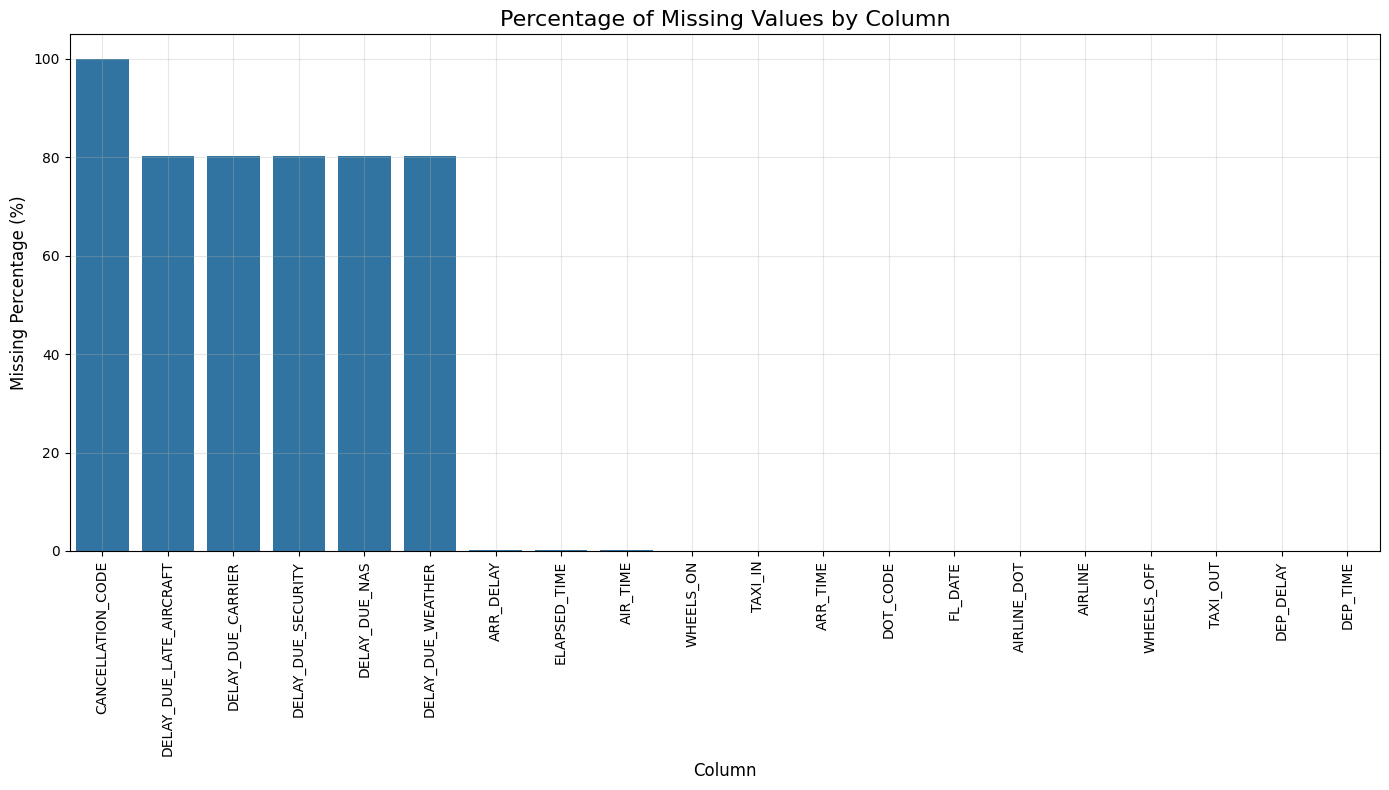

In [62]:
# Function to analyze missing values in the already filtered dataframe (df_after_drop)
def analyze_missing_values_in_filtered_df(df_after_drop):
    """Analyze missing values across the entire filtered dataframe (df_after_drop)."""
    missing_counts = {}
    total_rows = len(df_after_drop)  # Total rows after filtering
    
    # Count missing values in each column
    for col in df_after_drop.columns:
        missing = df_after_drop[col].isna().sum()
        missing_counts[col] = missing_counts.get(col, 0) + missing
    
    # Create a DataFrame to display missing values and their percentages
    missing_df = pd.DataFrame({
        'Column': list(missing_counts.keys()),
        'Missing Values': list(missing_counts.values()),
        'Missing Percentage': [count / total_rows * 100 for count in missing_counts.values()]
    }).sort_values('Missing Percentage', ascending=False)
    
    return missing_df, total_rows

# Now that df_after_drop is available, analyze missing values directly
missing_df, total_rows = analyze_missing_values_in_filtered_df(df_after_drop)

# Print the total number of rows after filtering and show the missing value analysis
print(f"✅ Total number of rows (after filtering 2020 and cancelled): {total_rows:,}")
print("\nMissing value analysis:")
display(missing_df)

# Visualize missing values
plt.figure(figsize=(14, 8))
sns.barplot(x='Column', y='Missing Percentage', data=missing_df.head(20))
plt.title('Percentage of Missing Values by Column', fontsize=16)
plt.xlabel('Column', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Base Preprocessing Functions

Below are the core functions that will be used in the base preprocessing pipeline. These functions handle the fundamental data processing tasks that are common across all model types.

In [63]:
def identify_essential_columns_by_correlation(df, target='DEP_DELAY', threshold=0.1, plot=True):
    """
    Identify essential columns based on their correlation with the target variable.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The input DataFrame
    target : str
        The target column to calculate correlations against
    threshold : float
        The minimum absolute correlation value to consider a column essential
    plot : bool
        Whether to create a visualization of correlations
        
    Returns:
    --------
    list
        List of column names with correlation above the threshold
    """
    # Check if target is in the dataframe
    if target not in df.columns:
        print(f"Target column '{target}' not found in dataframe")
        return []
    
    # Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=['number'])
    
    # Calculate correlation with target
    if target in numeric_df.columns:
        correlations = numeric_df.corr()[target].abs().sort_values(ascending=False)
        
        # Select columns with correlation above threshold
        selected_columns = correlations[correlations > threshold].index.tolist()
        
        # Remove the target from the list
        if target in selected_columns:
            selected_columns.remove(target)
        
        # Visualization
        if plot:
            plt.figure(figsize=(12, 8))
            
            # Plot only top correlations for clarity if there are many columns
            if len(selected_columns) > 20:
                top_correlations = correlations.head(20)
            else:
                top_correlations = correlations[correlations > threshold]
            
            sns.barplot(x=top_correlations.values, y=top_correlations.index)
            plt.title(f'Absolute Correlation with {target}', fontsize=16)
            plt.xlabel('Absolute Correlation Value', fontsize=12)
            plt.ylabel('Features', fontsize=12)
            plt.axvline(x=threshold, color='red', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.legend()
            plt.tight_layout()
            plt.show()
        
        return selected_columns
    else:
        print(f"Target column '{target}' is not numeric")
        return []

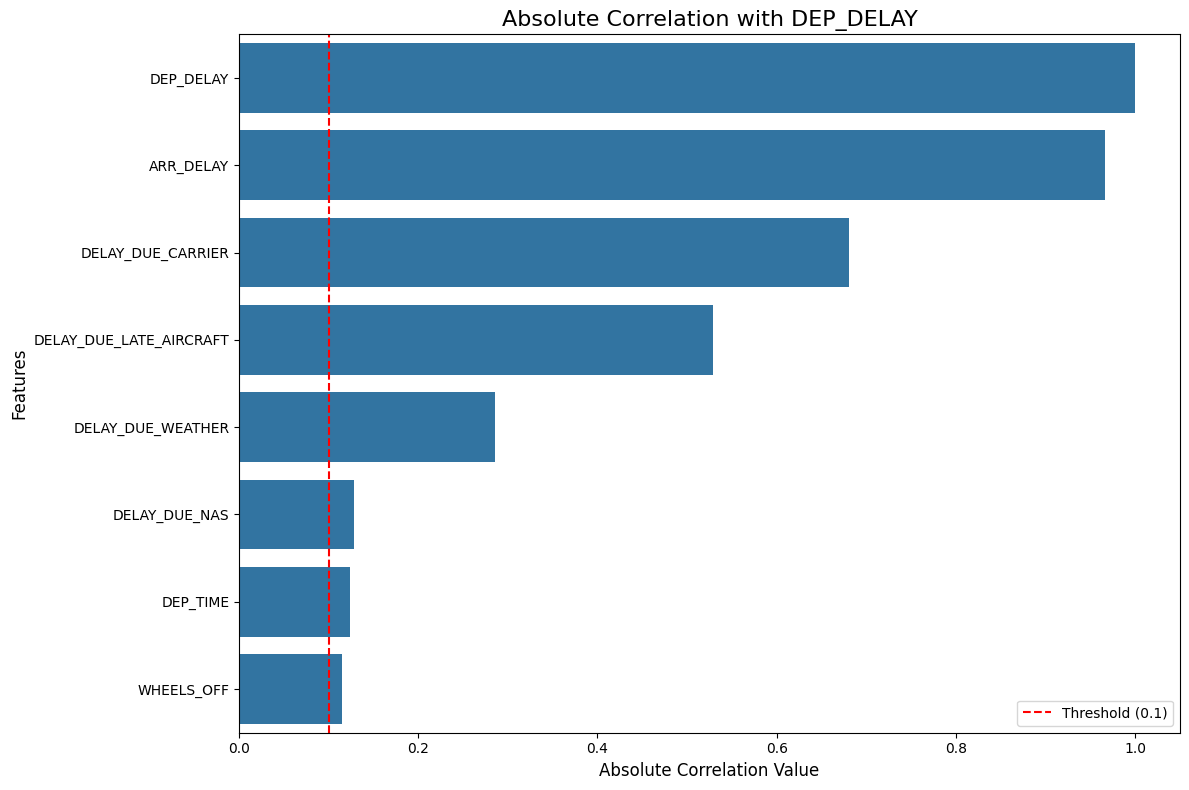


✅ Selected columns based on correlation:
['ARR_DELAY', 'DELAY_DUE_CARRIER', 'DELAY_DUE_LATE_AIRCRAFT', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DEP_TIME', 'WHEELS_OFF']


In [64]:
# --- Perform correlation analysis on df_after_drop ---
essential_cols = identify_essential_columns_by_correlation(
    df_after_drop,  # Directly use df_after_drop without using raw data
    target='DEP_DELAY',
    threshold=0.1,
    plot=True
)

print("\n✅ Selected columns based on correlation:")
print(essential_cols)


In [65]:
# Identify all columns in the dataframe
all_columns = df_after_drop.columns.tolist()

# Filter out the selected columns
selected_columns = ['DEP_TIME', 'WHEELS_OFF', 'ARR_DELAY', 'DELAY_DUE_CARRIER', 'DELAY_DUE_WEATHER', 'DELAY_DUE_NAS', 'DELAY_DUE_LATE_AIRCRAFT']
remaining_columns = [col for col in all_columns if col not in selected_columns]

# Display the remaining columns
print("Remaining columns that were not selected based on correlation:")
print(remaining_columns)


Remaining columns that were not selected based on correlation:
['FL_DATE', 'AIRLINE', 'AIRLINE_DOT', 'AIRLINE_CODE', 'DOT_CODE', 'FL_NUMBER', 'ORIGIN', 'ORIGIN_CITY', 'DEST', 'DEST_CITY', 'CRS_DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'DELAY_DUE_SECURITY']


In [66]:
import pandas as pd

# Function to perform feature engineering on the FL_DATE column
def feature_engineering_on_dates(df):
    """Create new features from FL_DATE for YEAR, QUARTER, MONTH, DAY_OF_MONTH, DAY_OF_WEEK"""
    if 'FL_DATE' in df.columns:
        df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')
        df['YEAR'] = df['FL_DATE'].dt.year
        df['QUARTER'] = df['FL_DATE'].dt.quarter
        df['MONTH'] = df['FL_DATE'].dt.month
        df['DAY_OF_MONTH'] = df['FL_DATE'].dt.day
        df['DAY_OF_WEEK'] = df['FL_DATE'].dt.dayofweek
    return df

# Assuming df_after_drop is the dataframe after the filtering steps are complete
modified_df = feature_engineering_on_dates(df_after_drop)

# Display first few rows to verify
print(modified_df.head())

# You can also print the columns to check if the new features are included
print(modified_df.columns)


     FL_DATE                 AIRLINE                 AIRLINE_DOT AIRLINE_CODE  \
0 2019-01-09   United Air Lines Inc.   United Air Lines Inc.: UA           UA   
1 2022-11-19    Delta Air Lines Inc.    Delta Air Lines Inc.: DL           DL   
2 2022-07-22   United Air Lines Inc.   United Air Lines Inc.: UA           UA   
3 2023-03-06    Delta Air Lines Inc.    Delta Air Lines Inc.: DL           DL   
4 2019-07-31  Southwest Airlines Co.  Southwest Airlines Co.: WN           WN   

   DOT_CODE  FL_NUMBER ORIGIN          ORIGIN_CITY DEST          DEST_CITY  \
0     19977       1562    FLL  Fort Lauderdale, FL  EWR         Newark, NJ   
1     19790       1149    MSP      Minneapolis, MN  SEA        Seattle, WA   
2     19977        459    DEN           Denver, CO  MSP    Minneapolis, MN   
3     19790       2295    MSP      Minneapolis, MN  SFO  San Francisco, CA   
4     19393        665    DAL           Dallas, TX  OKC  Oklahoma City, OK   

   CRS_DEP_TIME  DEP_TIME  DEP_DELAY  TAXI_O

In [67]:
# # Define essential columns for all model types
# def identify_essential_columns(df):
#     """
#     Identify essential columns that should be kept across all model types.
#     This function helps remove unnecessary columns early in the pipeline.
#     """
#     # Column groups to keep
#     essential_columns = [
#         # Identifiers and dates
#         'FL_DATE', 'YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
        
#         # Flight information
#         'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME',
#         'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 
        
#         # Arrival information
#         'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
        
#         # Additional useful information
#         'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
#         'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
#         'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'
#     ]
    
#     # Keep only columns that exist in the dataframe
#     existing_columns = [col for col in essential_columns if col in df.columns]
    
#     return existing_columns

In [68]:
# Clean and convert data types
def clean_and_convert_types(df):
    """
    Clean the dataframe and convert data types for efficiency
    """
    df_cleaned = df.copy()
    
    # Set negative delay values to zero
    delay_columns = ['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 
                    'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
    for col in delay_columns:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].clip(lower=0)
    
    # Convert time fields to proper format if they're not already datetime
    time_columns = ['DEP_TIME', 'CRS_DEP_TIME', 'ARR_TIME', 'CRS_ARR_TIME']
    for col in time_columns:
        if col in df_cleaned.columns and not pd.api.types.is_datetime64_dtype(df_cleaned[col]):
            # Handle time as integer in HHMM format
            try:
                # Convert times like 1030 (10:30 AM) to proper time format
                df_cleaned[col] = df_cleaned[col].astype(float)
                df_cleaned[col] = (df_cleaned[col] // 100).astype(int) * 60 + (df_cleaned[col] % 100).astype(int)
            except:
                pass
    
    # Convert categorical columns to category type
    categorical_cols = ['OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE']
    for col in categorical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype('category')
    
    # Convert boolean columns to boolean type
    binary_cols = ['CANCELLED', 'DIVERTED']
    for col in binary_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = df_cleaned[col].astype(bool)
    
    return df_cleaned

In [69]:
cleaned_df = clean_and_convert_types(modified_df)
print(f"✅ Cleaned DataFrame shape: {cleaned_df.shape}")

# Optional: preview
display(cleaned_df.head())

✅ Cleaned DataFrame shape: (2470267, 37)


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",715,711,0.0,19.0,1210.0,1443.0,4.0,901,1447.0,0.0,False,NaN,False,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,2019,1,1,9,2
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",1280,1274,0.0,9.0,2123.0,2232.0,38.0,1395,2310.0,0.0,False,NaN,False,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,2022,4,11,19,5
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,False,NaN,False,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,2022,3,7,22,4
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",969,968,0.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,False,NaN,False,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,2023,1,3,6,0
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,False,NaN,False,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0,2019,3,7,31,2


In [70]:
# Create common derived features useful for all model types
def create_common_features(df):
    """
    Create new features that are beneficial across all model types
    """
    df_featured = df.copy()
    
    # Extract time components if we have FL_DATE
    if 'FL_DATE' in df_featured.columns:
        # Extract date components if not already present
        if 'YEAR' not in df_featured.columns:
            df_featured['YEAR'] = df_featured['FL_DATE'].dt.year
        if 'MONTH' not in df_featured.columns:
            df_featured['MONTH'] = df_featured['FL_DATE'].dt.month
        if 'DAY_OF_MONTH' not in df_featured.columns:
            df_featured['DAY_OF_MONTH'] = df_featured['FL_DATE'].dt.day
        if 'DAY_OF_WEEK' not in df_featured.columns:
            df_featured['DAY_OF_WEEK'] = df_featured['FL_DATE'].dt.dayofweek + 1  # 1-based (1=Monday)
        
        # Create quarter if not present
        if 'QUARTER' not in df_featured.columns:
            df_featured['QUARTER'] = df_featured['FL_DATE'].dt.quarter
        
        # Create season
        df_featured['SEASON'] = df_featured['MONTH'].apply(lambda x: 
            1 if x in [12, 1, 2] else  # Winter
            2 if x in [3, 4, 5] else   # Spring
            3 if x in [6, 7, 8] else   # Summer
            4                          # Fall
        )
        
        # Is holiday season flag (November-December)
        df_featured['IS_HOLIDAY_SEASON'] = df_featured['MONTH'].isin([11, 12]).astype(int)
    
    # Extract hour from departure time if available and in the right format
    if 'CRS_DEP_TIME' in df_featured.columns:
        try:
            # If it's in minutes format (converted earlier)
            if df_featured['CRS_DEP_TIME'].dtype != 'object':
                df_featured['DEP_HOUR'] = df_featured['CRS_DEP_TIME'] // 60
            # If it's in HHMM format
            else:
                df_featured['DEP_HOUR'] = df_featured['CRS_DEP_TIME'].astype(str).str[:2].astype(float)
            
            # Time of day category
            df_featured['TIME_OF_DAY'] = pd.cut(
                df_featured['DEP_HOUR'], 
                bins=[0, 6, 12, 18, 24], 
                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                right=False
            )
        except:
            print("Could not create time of day features from CRS_DEP_TIME")
    
    # Create binary indicators for cancelled and diverted flights
    if 'CANCELLED' in df_featured.columns and df_featured['CANCELLED'].dtype == bool:
        df_featured['CANCELLED'] = df_featured['CANCELLED'].astype(int)
    
    if 'DIVERTED' in df_featured.columns and df_featured['DIVERTED'].dtype == bool:
        df_featured['DIVERTED'] = df_featured['DIVERTED'].astype(int)
    
    # Calculate scheduled departure and arrival times in minutes since midnight
    # This is more useful for models than HHMM format
    if 'CRS_DEP_TIME' in df_featured.columns:
        try:
            if isinstance(df_featured['CRS_DEP_TIME'].iloc[0], (int, float)):
                if df_featured['CRS_DEP_TIME'].max() > 2400:  # Already in minutes
                    df_featured['CRS_DEP_TIME_MINUTES'] = df_featured['CRS_DEP_TIME']
                else:  # HHMM format
                    df_featured['CRS_DEP_TIME_MINUTES'] = (df_featured['CRS_DEP_TIME'] // 100) * 60 + (df_featured['CRS_DEP_TIME'] % 100)
        except:
            print("Could not convert CRS_DEP_TIME to minutes")
    
    if 'CRS_ARR_TIME' in df_featured.columns:
        try:
            if isinstance(df_featured['CRS_ARR_TIME'].iloc[0], (int, float)):
                if df_featured['CRS_ARR_TIME'].max() > 2400:  # Already in minutes
                    df_featured['CRS_ARR_TIME_MINUTES'] = df_featured['CRS_ARR_TIME']
                else:  # HHMM format
                    df_featured['CRS_ARR_TIME_MINUTES'] = (df_featured['CRS_ARR_TIME'] // 100) * 60 + (df_featured['CRS_ARR_TIME'] % 100)
        except:
            print("Could not convert CRS_ARR_TIME to minutes")
    
    return df_featured

In [71]:
new_modified_df = create_common_features(cleaned_df)


In [72]:
new_modified_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2470267 entries, 0 to 2470266
Data columns (total 41 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   FL_DATE                  datetime64[ns]
 1   AIRLINE                  object        
 2   AIRLINE_DOT              object        
 3   AIRLINE_CODE             object        
 4   DOT_CODE                 int64         
 5   FL_NUMBER                int64         
 6   ORIGIN                   category      
 7   ORIGIN_CITY              object        
 8   DEST                     category      
 9   DEST_CITY                object        
 10  CRS_DEP_TIME             int64         
 11  DEP_TIME                 int64         
 12  DEP_DELAY                float64       
 13  TAXI_OUT                 float64       
 14  WHEELS_OFF               float64       
 15  WHEELS_ON                float64       
 16  TAXI_IN                  float64       
 17  CRS_ARR_TIME             in

In [73]:
# Handle exact duplicate records
def handle_duplicates(df):
    """
    Remove exact duplicate records (i.e., all columns identical)
    """
    dup_count = df.duplicated(keep=False).sum()
    if dup_count > 0:
        print(f"Found {dup_count} exact duplicate records.")
        df = df.drop_duplicates()
        print(f"Removed {dup_count} exact duplicate records.")
    return df
new_modified_df = handle_duplicates(new_modified_df)
print(f"✅ Data shape after removing duplicates: {new_modified_df.shape}")

✅ Data shape after removing duplicates: (2470267, 41)


## Execute the Base Preprocessing Pipeline

Now we'll run the complete base preprocessing pipeline on the entire dataset, processing the data in chunks to handle the large file size.

In [74]:
import os
import pandas as pd
from datetime import datetime

def save_dataframe_in_chunks(df, output_file, chunk_size=500000):
    """
    Save a large DataFrame to CSV in smaller chunks to avoid memory issues
    """
    total_rows = len(df)
    total_columns = df.shape[1]
    total_chunks = (total_rows // chunk_size) + 1
    print(f"Saving {total_rows:,} rows and {total_columns:,} columns to {output_file} in {total_chunks} chunks...")

    for i in range(0, total_rows, chunk_size):
        chunk = df.iloc[i:i + chunk_size]
        mode = 'w' if i == 0 else 'a'  # Write mode for the first chunk, append mode for others
        header = i == 0  # Only include the header for the first chunk
        chunk.to_csv(output_file, mode=mode, header=header, index=False)  # Saving to CSV
        print(f"✅ Chunk {i//chunk_size + 1}/{total_chunks}: Saved {len(chunk):,} rows")

    print(f"\n✅ Done saving to {output_file}")
    print(f"🧾 Final shape of saved data: {df.shape[0]:,} rows × {df.shape[1]:,} columns")


In [75]:
output_file = os.path.join(PROCESSED_DATA_PATH, 'base_preprocessed_flights.csv')

total_processed = save_dataframe_in_chunks(new_modified_df, output_file)



Saving 2,470,267 rows and 41 columns to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv in 5 chunks...
✅ Chunk 1/5: Saved 500,000 rows
✅ Chunk 2/5: Saved 500,000 rows
✅ Chunk 3/5: Saved 500,000 rows
✅ Chunk 4/5: Saved 500,000 rows
✅ Chunk 5/5: Saved 470,267 rows

✅ Done saving to c:\xampp\htdocs\Forecasting_Flights-DataScience\data\processed\base_preprocessed_flights.csv
🧾 Final shape of saved data: 2,470,267 rows × 41 columns


In [76]:
# Verify the output file
try:
    # Read a sample of the processed data
    processed_sample = pd.read_csv(output_file, nrows=1000)
    print(f"Processed data shape: {processed_sample.shape}")
    print("\nColumns in processed data:")
    for col in processed_sample.columns:
        print(f"- {col}: {processed_sample[col].dtype}")
    
    print("\nSample of processed data:")
    display(processed_sample.head())
    
    # Check if key derived features are present
    expected_features = ['SEASON', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON']
    present_features = [col for col in expected_features if col in processed_sample.columns]
    print(f"\nNew derived features created: {present_features}")
    
except Exception as e:
    print(f"Error reading processed file: {e}")

Processed data shape: (1000, 41)

Columns in processed data:
- FL_DATE: object
- AIRLINE: object
- AIRLINE_DOT: object
- AIRLINE_CODE: object
- DOT_CODE: int64
- FL_NUMBER: int64
- ORIGIN: object
- ORIGIN_CITY: object
- DEST: object
- DEST_CITY: object
- CRS_DEP_TIME: int64
- DEP_TIME: int64
- DEP_DELAY: float64
- TAXI_OUT: float64
- WHEELS_OFF: float64
- WHEELS_ON: float64
- TAXI_IN: float64
- CRS_ARR_TIME: int64
- ARR_TIME: float64
- ARR_DELAY: float64
- CANCELLED: int64
- CANCELLATION_CODE: float64
- DIVERTED: int64
- CRS_ELAPSED_TIME: float64
- ELAPSED_TIME: float64
- AIR_TIME: float64
- DISTANCE: float64
- DELAY_DUE_CARRIER: float64
- DELAY_DUE_WEATHER: float64
- DELAY_DUE_NAS: float64
- DELAY_DUE_SECURITY: float64
- DELAY_DUE_LATE_AIRCRAFT: float64
- YEAR: int64
- QUARTER: int64
- MONTH: int64
- DAY_OF_MONTH: int64
- DAY_OF_WEEK: int64
- SEASON: int64
- IS_HOLIDAY_SEASON: int64
- DEP_HOUR: int64
- TIME_OF_DAY: object

Sample of processed data:


,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,SEASON,IS_HOLIDAY_SEASON,DEP_HOUR,TIME_OF_DAY
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",715,711,0.0,19.0,1210.0,1443.0,4.0,901,1447.0,0.0,0,NaN,0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN,2019,1,1,9,2,1,0,11,Morning
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",1280,1274,0.0,9.0,2123.0,2232.0,38.0,1395,2310.0,0.0,0,NaN,0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN,2022,4,11,19,5,4,1,21,Evening
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",594,600,6.0,20.0,1020.0,1247.0,5.0,772,1252.0,0.0,0,NaN,0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN,2022,3,7,22,4,3,0,9,Morning
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",969,968,0.0,27.0,1635.0,1844.0,9.0,1109,1853.0,24.0,0,NaN,0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0,2023,1,3,6,0,2,0,16,Afternoon
4,2019-07-31,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,665,DAL,"Dallas, TX",OKC,"Oklahoma City, OK",610,757,147.0,15.0,1252.0,1328.0,3.0,670,1331.0,141.0,0,NaN,0,60.0,54.0,36.0,181.0,141.0,0.0,0.0,0.0,0.0,2019,3,7,31,2,3,0,10,Morning



New derived features created: ['SEASON', 'TIME_OF_DAY', 'IS_HOLIDAY_SEASON']


## Summary of Base Preprocessing

The base preprocessing pipeline has:

1. Removed data from 2020 due to COVID-19 irregularities and cancelled flights
2. highlighted essential columns for all model types
3. Converted data types for efficiency and consistency
4. Detected and removed duplicate flight records
5. Created common derived features beneficial for all analyses
6. Processed the data in chunks to handle the large dataset
7. Saved the result for use by specialized pipelines


